In [ ]:
%pip install prophet pandas matplotlib statsmodels scikit-learn xgboost

### Importación de Librerías
Las siguientes librerías son necesarias para el análisis y modelado, se utilizara xgboost para el modelado predictivo.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Constants for DataFrame Columns

START_DATE = 'FECHA HECHO'
AMOUNT = 'CANTIDAD'
ID_DEPTO = 'COD_DEPTO'
ID_MUNI = 'COD_MUNI'
DEPTO = 'DEPARTAMENTO'
MUNI = 'MUNICIPIO'
ACTION = 'ACCION'
YEAR = 'AÑO'

## Constants grouping
SEMESTER = 'SEMESTRE'
PERIOD = 'PERIODO'
PRED_QUANTITY = 'CANTIDAD_PRED'
PRED = 'PREDICCION'



#### 1. Carga y Limpieza de Datos

1. Se lee el archivo CSV y se carga en un DataFrame.
2. Se convierte la columna 'FECHA HECHO' a formato de fecha usando el formato día/mes/año.
3. Se seleccionan solo las columnas 'FECHA HECHO' y 'CANTIDAD', eliminando filas con valores nulos.


In [27]:
df = pd.read_csv('data/AFECTACI_N_DE_MIEMBROS_DE_LA_FUERZA_P_BLICA_20250616.csv', encoding='utf-8')
df[START_DATE] = pd.to_datetime(df[START_DATE], format='%d/%m/%Y')
df = df[[START_DATE, AMOUNT]].dropna()

#### 2. Agrupación semestral
1. Se agrupan los datos por semestre, sumando las cantidades de cada semestre.
2. Se crea una nueva columna 'SEMESTRE' que indica el semestre correspondiente a cada fila.
3. Se eliminan las filas con valores nulos en la columna 'SEMESTRE

In [28]:
df[YEAR] = df[START_DATE].dt.year
df[SEMESTER] = np.where(df[START_DATE].dt.month <= 6, 1, 2)
df[PERIOD] = df[YEAR].astype(str) + "-S" + df[SEMESTER].astype(str)

df_grouped = df.groupby([PERIOD, YEAR, SEMESTER]).agg({AMOUNT: 'sum'}).reset_index()

#### 3. División Entrenamiento y Prueba
1. Se divide el DataFrame en conjuntos de entrenamiento y prueba
2. Se utiliza el 80% de los datos para entrenamiento y el 20% restante para prueba.

In [29]:
x = df_grouped[[YEAR, SEMESTER]]
y = df_grouped[AMOUNT] 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### 4. Entrenamiento del Modelo
1. Se entrena un modelo XGBoost utilizando los datos de entrenamiento.
2. Se ajusta el modelo a los datos de entrenamiento.

In [30]:
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#### 5. Metricas de Evaluación
1. Se evalúa el modelo utilizando métricas como MAE, MSE y RMSE

In [31]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== MÉTRICAS DEL MODELO ===")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


=== MÉTRICAS DEL MODELO ===
RMSE: 179.23
R2: 0.76


#### 6. Real vs Predicción

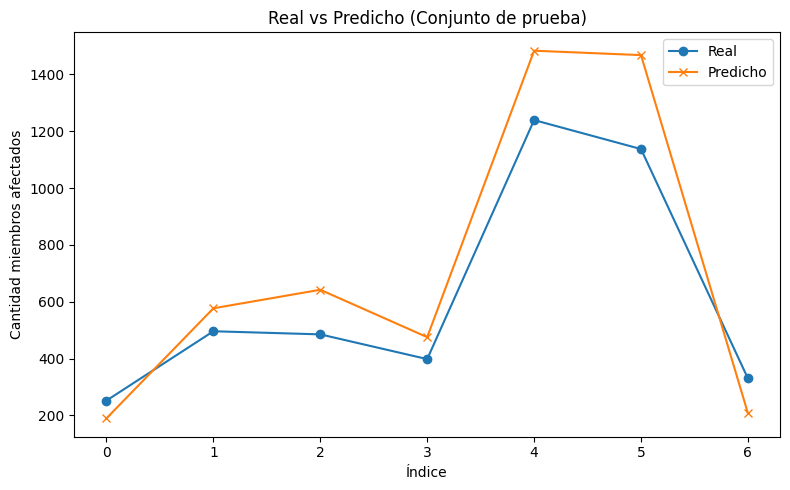

In [32]:
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred, label='Predicho', marker='x')
plt.title("Real vs Predicho (Conjunto de prueba)")
plt.xlabel("Índice")
plt.ylabel("Cantidad miembros afectados")
plt.legend()
plt.tight_layout()
plt.show()


#### 7. Dispersión Real vs Predicción

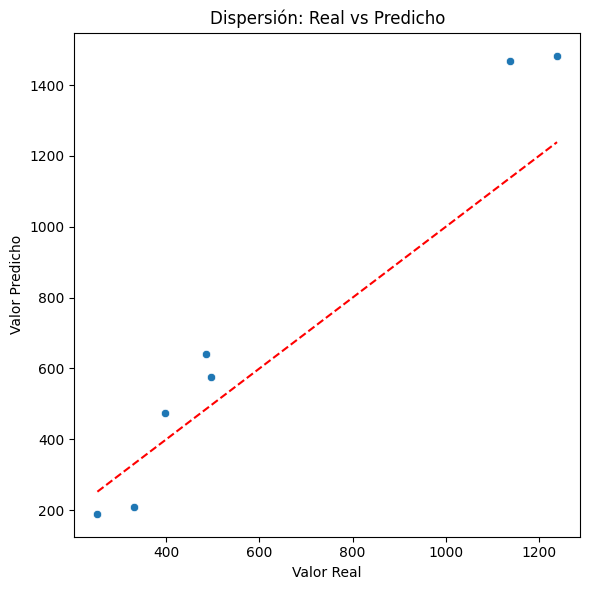

In [33]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Dispersión: Real vs Predicho")
plt.tight_layout()
plt.show()

#### 8. PREDICCIÓN EN TODO EL CONJUNTO

In [34]:
df_grouped[PRED_QUANTITY] = model.predict(df_grouped[[YEAR, SEMESTER]])

#### 9. TENDENCIA TEMPORAL COMPLETA
1. Se grafica la tendencia temporal completa de las cantidades afectadas a lo largo del tiempo

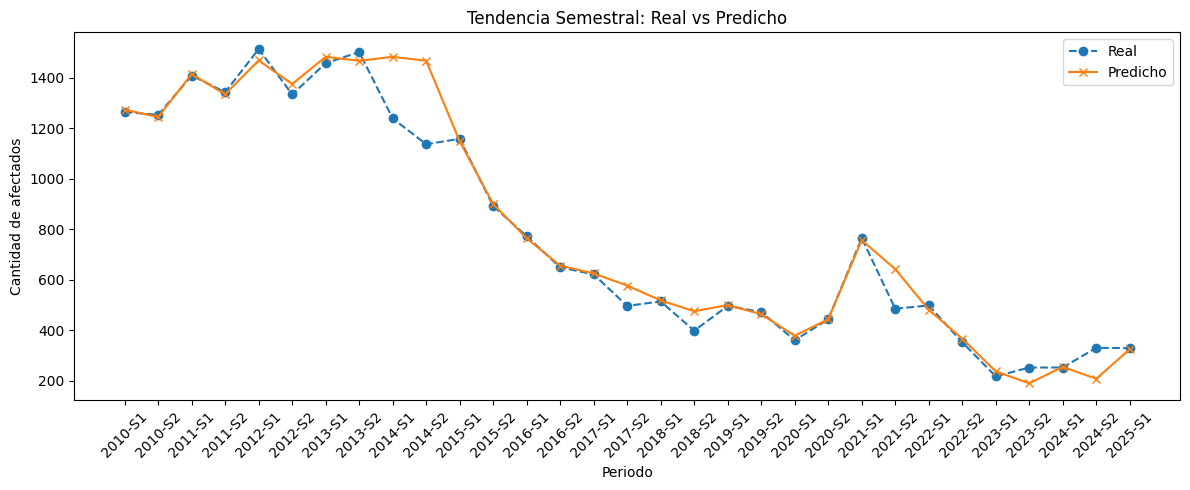

In [35]:
plt.figure(figsize=(12,5))
plt.plot(df_grouped[PERIOD], df_grouped[AMOUNT], label='Real', marker='o', linestyle='--')
plt.plot(df_grouped[PERIOD], df_grouped[PRED_QUANTITY], label='Predicho', marker='x')
plt.xticks(rotation=45)
plt.title("Tendencia Semestral: Real vs Predicho")
plt.xlabel("Periodo")
plt.ylabel("Cantidad de afectados")
plt.legend()
plt.tight_layout()
plt.show()


#### 10. Barras Reales vs Predichos

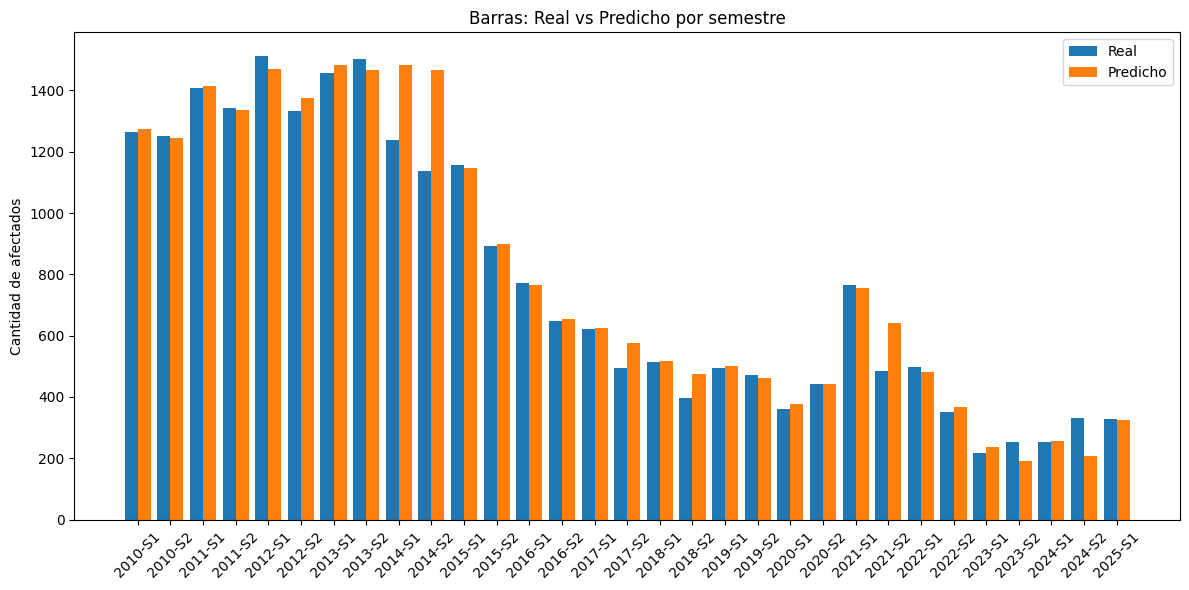

In [36]:
plt.figure(figsize=(12,6))
x = np.arange(len(df_grouped))
plt.bar(x - 0.2, df_grouped[AMOUNT], width=0.4, label='Real')
plt.bar(x + 0.2, df_grouped[PRED_QUANTITY], width=0.4, label='Predicho')
plt.xticks(x, df_grouped[PERIOD], rotation=45)
plt.title("Barras: Real vs Predicho por semestre")
plt.ylabel("Cantidad de afectados")
plt.legend()
plt.tight_layout()
plt.show()

#### 11. Heatmap Afectados por Semestre

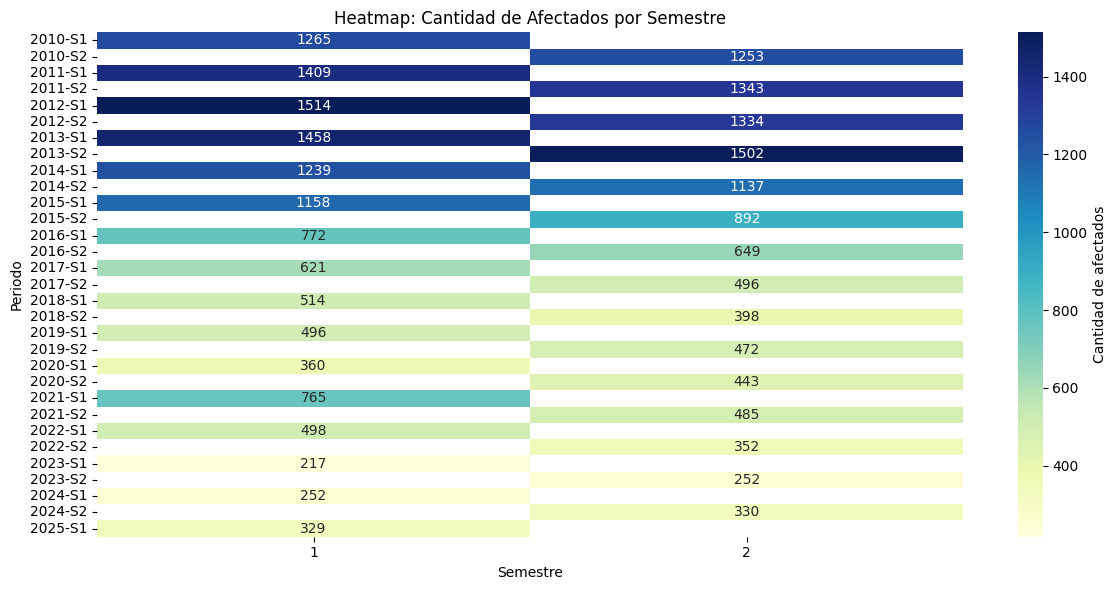

In [37]:
pivot_table = df_grouped.pivot(index=PERIOD, columns=SEMESTER, values=AMOUNT)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu', cbar_kws={'label': 'Cantidad de afectados'})
plt.title("Heatmap: Cantidad de Afectados por Semestre")
plt.xlabel("Semestre")
plt.ylabel("Periodo")
plt.tight_layout()
plt.show()

#### 12. "Heatmap de Afectaciones por Año y Semestre

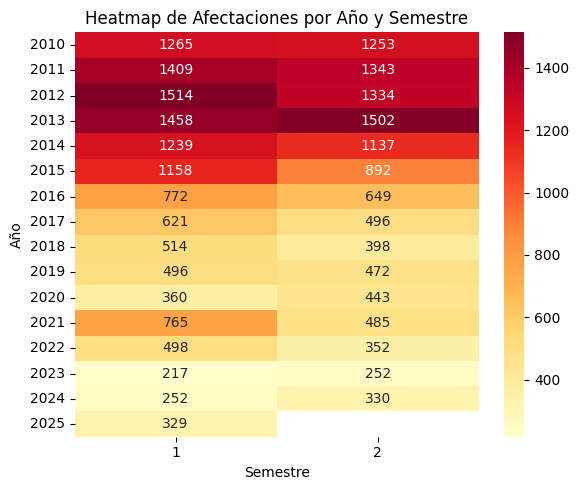

In [38]:
pivot = df_grouped.pivot(index=YEAR, columns=SEMESTER, values=AMOUNT)
plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title("Heatmap de Afectaciones por Año y Semestre")
plt.xlabel("Semestre")
plt.ylabel("Año")
plt.tight_layout()
plt.show()

#### 13. Predicción de Afectaciones Futuras

In [ ]:
print("\n=== PREDICCIÓN PARA PRÓXIMOS 2 SEMESTRES ===")
last_year = df_grouped[YEAR].max()
last_semester = df_grouped[df_grouped[YEAR] == last_year][SEMESTER].max()

futuros = []
for i in range(2):
    if last_semester == 1:
        next_year = last_year
        next_semester = 2
    else:
        next_year = last_year + 1
        next_semester = 1
    futuros.append([next_year, next_semester])
    last_year, last_semester = next_year, next_semester

df_future = pd.DataFrame(futuros, columns=[YEAR, SEMESTER])
df_future[PRED] = model.predict(df_future)
df_future[PERIOD] = df_future[YEAR].astype(str) + "-S" + df_future[SEMESTER].astype(str)

print(df_future[[PERIOD, PRED]])



=== PREDICCIÓN PARA PRÓXIMOS 2 SEMESTRES ===
   PERIODO  PREDICCION
0  2025-S2  277.373840
1  2026-S1  324.621338
